In [44]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error

In [45]:
# laod data
path = './_data/kaggle_house/'
train_df =  pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv') 

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


판다스 라이브러리 기능으로 트레인 데이터 상단부분을 출력하여 확인했다.

In [46]:
# set index
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

len_train_df = len(train_df) #print(len_train_df) #1460
len_test_df = len(test_df) #print(len_test_df) #1459

corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>=0.3]
top_corr_features


Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

1. inplace = True /False
 True  : set_index가 적용된 DataFrame 자체를 변경한다.
 False : set_index가 적용된 DateFrame은 원본 그대로 두고 다른 변수에 set_index가 적용된 DateFrame을 할당한다. (False가 디폴트값이다.)

 2. train_df와 test_df의 갯수를 세어보니 각각 1460, 1459이다.

 3. corr()함수를 통해 dataframe내의 모든 변수간의 상관관계를 그려보았다. 고려해야 할 변수가 많을 때는 각 독립변수와 종속변수 간의 상광관계를 검토해보는 것이 좋다. 모든 변수 중에 좀 더 의미 있는 변수만을 골라내어 모델을 구축하는 것이 모델의 예측 정확도를 높이는 방법이다. 상관관계를 검토하는 corr()함수를 통해 dataframe내의 모든 변수간의 상관관계를 그린 후 SalePrice와 상관관계가 0.3 이상인 변수만 인덱스를 이용해 리스트화한다.

In [47]:
# split y_label
train_y_label = train_df['SalePrice'] 	# target 값을 미리 분리하였음.
train_df.drop(['SalePrice'], axis=1, inplace=True)

# concat train & test
boston_df = pd.concat((train_df, test_df), axis=0)
boston_df_index = boston_df.index

print('Length of Boston Dataset : ',len(boston_df))
boston_df.head()

Length of Boston Dataset :  2919


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


1. train_df의 SalePrice를 target값으로 분류해 train_y_label 변수에 저장한다.
그러기 위해서는 train_df의 SalePrice를 드롭시키며 이때, DataFrame 자체를 변경한다. (inplace=True)

2. train과 test 셋에 동일한 feature engineering을 적용해주기 위해 우선 두개의 데이터 셋을 하나로 합쳐주었다. 피처엔지니어링이란 현재 존재하는 변수를 활용해 새로운 정보를 추가로 생성하는 과정을 말한다.

3. Boston Dataset을 합쳐준 후 출력해보니 2919개로 데이터가 늘었다.

In [48]:
# check null 
check_null = boston_df.isna().sum() / len(boston_df)
# columns of null ratio >= 0.5
check_null[check_null >= 0.5]



Alley          0.932169
PoolQC         0.996574
Fence          0.804385
MiscFeature    0.964029
dtype: float64


데이터를 처리할 때 항상 null값을 어떻게 처리할지 고민해야한다. 추후 모델에 입력되는 input 값에는 절대 
어떠한 null 값이 있어서는 안되며 있더라도 에러가 발생하기 때문에 미리 처리를 해주는 것이다.

In [49]:
# remove columns of null ratio >= 0.5
remove_cols = check_null[check_null >= 0.5].keys()
boston_df = boston_df.drop(remove_cols, axis=1)

boston_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


우선 각 컬럼별로 null 값 비율이 50% 이상인 칼럼을 찾아 해당 칼럼을 제거해주었다.
보통 null값 처리를 위해서는 평균, 최대값, 최소값 등으로 대체하는데,
Alley / PoolQC / Fence / MiscFeature 칼럼을 보니 데이터가 거의 null값을 가지므로 제거해주었다.

그 후, 판다스 라이브러리 기능으로 데이터가 잘 제거되었는지 데이터 상단부분을 출력하여 확인했다.

In [50]:
# split object & numeric
boston_obj_df = boston_df.select_dtypes(include='object')	# 카테고리형
boston_num_df = boston_df.select_dtypes(exclude='object')	# 수치형

print('Object type columns:\n',boston_obj_df.columns)
print('---------------------------------------------------------------------------------')
print('Numeric type columns:\n',boston_num_df.columns)


Object type columns:
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
---------------------------------------------------------------------------------
Numeric type columns:
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFul

해당 데이터 셋에는 수치형 데이터만 있는 것이 아니다. [성별: 남자, 여자], [학급: 햇님반, 꽃님반, 달님반]과 같은 카테고리형 데이터도 존재한다.
이러한 카테고리형 데이터는 각 칼럼을 0과 1로 변환해주는 one-hot encoding을 적용해주어 수치값과 가중치를 달리해주어야 한다.
수치형 데이터와 카테고리형 데이터를 구분하기 위해 select_dtypes()를 이용하였다. 
parameter값으로 include와 exclude를 적용하여 데이터를 분리하였다.

이후, 카테고리형과 수치형으로 잘 분리되어 있는지 확인하고자 출력해보았다. 

In [51]:

boston_dummy_df = pd.get_dummies(boston_obj_df, drop_first=True)
boston_dummy_df.index = boston_df_index
boston_dummy_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


위에서 분리한 카테고리형 데이터에 one-hot-encodind을 적용하기 위해 pandas의 pd.get_dummies()를 적용하였다. 이때, pd.get_dummies는 결측값을 제외하고 0과 1로 구성된 더미값이 만들어지도록 처리하였는데, n-1개의 열을 만들기 위해 drop_first = True로 옵션을 지정해주었다.그리고 판다스 라이브러리 기능으로 데이터가 0과 1로 구성된 더미값이 잘 만들어졌는지 데이터 상단부분을 출력하여 확인했다.


In [52]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(boston_num_df)
boston_num_df_ = imputer.transform(boston_num_df)

boston_num_df = pd.DataFrame(boston_num_df_, columns=boston_num_df.columns, index=boston_df_index)
boston_num_df.head()



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
2,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
3,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
5,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


null 값이 50% 이상인 변수들을 제거해주었는데, 50% 이하로 null 값이 있는 데이터를 마저 처리해주어야 한다.
각 컬럼의 null 값을 해당하는 각 변수들의 평균으로 대체해주었다.

평균값 대체를 위하여 scikit-learn의 Imputer 함수를 이용하였으며, strategy 값에 대체해주고자 하는 이름을 넣어주면 해당 값으로 처리한다.

SimpleImputer 는 현재 제거 된 이전 sklearn.preprocessing.Imputer 추정기를 대체하는 버전 0.20의 새로운 기능이다. 그 후, 판다스 라이브러리 기능으로 null 값이 있는 데이터들이 잘 처리되어있는지 출력하여 확인했다.

In [53]:
pd.set_option('mode.chained_assignment',  None)

boston_df = pd.merge(boston_dummy_df, boston_num_df, left_index=True, right_index=True)
boston_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
2,0,0,1,0,1,0,0,1,0,0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
3,0,0,1,0,1,0,0,0,0,0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,0,0,1,0,1,0,0,0,0,0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
5,0,0,1,0,1,0,0,0,0,0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


위에서 각각 처리한 카테고리현 데이터와 수치형 데이터를 이제 최종적으로 다시 하나로 merge해준다. 
merge시 index 순서가 꼬이지 않게 left_index=True, right_index=True를 지정하여 merge를 수행한다.

In [54]:
train_df = boston_df[:len_train_df]
test_df = boston_df[len_train_df:]

train_df['SalePrice']= train_y_label

print('train set length: ',len(train_df))
print('test set length: ',len(test_df))

train set length:  1460
test set length:  1459


모델 학습 및 검증을 위해 데이터를 train과 test로 split 할것이다.
SalePrice는 train_y_label으로 설정하였다.
train/test set length를 출력해보니 각각 1460, 1459개이다.

In [55]:
from sklearn.model_selection import train_test_split

X_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)

X_test = test_df
test_id_idx = test_df.index

print('X_train : ',len(X_train))
print('X_val : ',len(X_val))
print('X_test :',len(X_test))


X_train :  1022
X_val :  438
X_test : 1459


scikit-learn 모델의 train_test_split을 이용해 train과 test로 split 할것인데,
먼저 X_train의 SalePrice 값을 y_train으로 설정하였다.
그리고 test set의 경우 정답값이 없는 예측해야 하는 값이므로 검증을 위해 validation set( X_val,  y_val)을 train set의 30%만큼으로 지정해주고 섞어주었다.

데이터를 섞어준 후 출력해보니 X_train :  1022 / X_val :  438 / X_test : 1459 값으로 확인되었으며
최종적으로 1022데이터로 학습 후, 438개 데이터로 검증하고, 1459개의 test_set을 예측한다.

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

예측을 하기 위해서 regreesion 예측 즉, 회귀분석의 XGBoost 모델을 이용하였다. xgboost는 모델 학습을 위해 최근 캐글에서 가장 인기 있는 모델로 꼽히고 있다고 한다.

모델 하이퍼 파라미터에 넣을 수 있는 값들을 순차적으로 입력한 뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법인 grid search 즉, 격자탐색으로 최적의 모델로 파라미터 설정을 하였다.

학습 후 bestparams를 출력하여 최적의 파라미터 값이 출력된다.

train mae score:  5391.43605140044
val mae score: 4067.49618293379


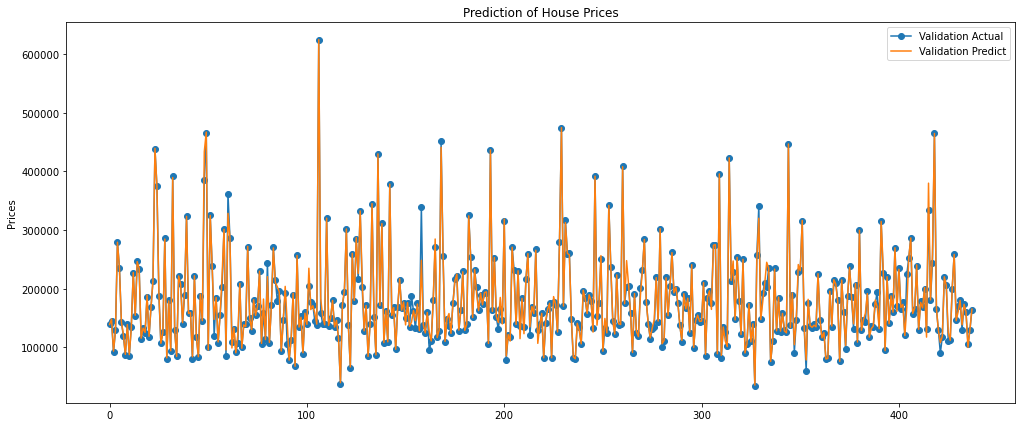

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_train = grid_search.predict(X_train)
pred_val = grid_search.predict(X_val)

print('train mae score: ', mean_absolute_error(y_train, pred_train))
print('val mae score:', mean_absolute_error(y_val, pred_val))

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_val)), y_val,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '-', label='Validation Predict')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

검증을 위해 Mean Absolute Error(MAE) 지표를 활용하였다. MSE를 활용할 경우 error값이 클 경우 그에 제곱된 값이 출력되기 때문에 값이 너무 커져 보기 불편하다는 단점이 있다.

이후 validation set을 대상으로 예측을 수행한 후 실제 값과의 결과를 plotting하였다. 

In [41]:

test_y_pred = grid_search.predict(X_test)
id_pred_df = pd.DataFrame()
id_pred_df['Id'] = test_id_idx
id_pred_df['SalePrice'] = test_y_pred
print(id_pred_df)

id_pred_df.to_csv(path + 'submission.csv', index=False)

        Id      SalePrice
0     1461  131389.328125
1     1462  163367.125000
2     1463  181614.781250
3     1464  189535.453125
4     1465  172757.078125
...    ...            ...
1454  2915   72782.726562
1455  2916   64634.003906
1456  2917  172345.125000
1457  2918  121506.468750
1458  2919  231789.593750

[1459 rows x 2 columns]
